# Import & read data

In [89]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold, KFold

In [90]:
import re

In [91]:
import functools

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [93]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [94]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from lightgbm import LGBMClassifier
import gc

In [95]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [97]:
# Train test

from sklearn.model_selection import train_test_split

train_back, test_back, _ , y_test = train_test_split(train_df, train_df['loan_default'], random_state = 40, train_size = 0.6)
test_back.drop('loan_default', inplace = True, axis = 1)

train = train_back.copy()
test = test_back.copy()

C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [167]:
# Whole Dataset
train = train_df.copy()
test = test_df.copy()

In [168]:
train.shape, test.shape

((233154, 41), (112392, 40))

In [10]:
T = train.shape[0]
P = len(train[train['loan_default'] == 1])
# scale_pos_weight = percent of negative / percent of positive
# which translates to:
# scale_pos_weight = (100*(T-P)/T) / (100*P/T)
# which further simplifies to beautiful:
scale_pos_weight = T/P - 1

In [11]:
scale_pos_weight

3.606785086246073

In [169]:
def augment(train,num_n=1,num_p=2):
    newtrain=[train]
    
    n=train[train.loan_default==0]
    for i in range(num_n):
        newtrain.append(n.apply(lambda x:x.values.take(np.random.permutation(len(n)))))
    
    for i in range(num_p):
        p=train[train.loan_default>0]
        newtrain.append(p.apply(lambda x:x.values.take(np.random.permutation(len(p)))))
    return pd.concat(newtrain)

# Pre-processing

In [170]:
train[['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']] = train[['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']].applymap( lambda z: functools.reduce(lambda a,b : 12*a+b, [int(s) for s in re.findall(r'\d+', z)]));
test[['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']] = test[['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']].applymap( lambda z: functools.reduce(lambda a,b : 12*a+b, [int(s) for s in re.findall(r'\d+', z)]));

In [171]:
#Clip outliers
num_col = ['PRI.NO.OF.ACCTS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'PERFORM_CNS.SCORE', 'SEC.INSTAL.AMT',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'SEC.CURRENT.BALANCE', 'ltv', 
       'disbursed_amount', 'PRIMARY.INSTAL.AMT',
       'PRI.SANCTIONED.AMOUNT', 'asset_cost', 'PRI.DISBURSED.AMOUNT',
       'PRI.CURRENT.BALANCE']
for c in num_col:
    train[c] = train[c].clip(lower=(train[c].mean() - 3*train[c].std()), upper=(train[c].mean() + 3*train[c].std()))
    test[c] = test[c].clip(lower=(test[c].mean() - 3*test[c].std()), upper=(test[c].mean() + 3*test[c].std()))

In [172]:
train['Date.of.Birth'] = train['Date.of.Birth'].apply(pd.to_datetime).dt.year.apply(lambda x: x if x<2010 else x - 100).apply(int)
test['Date.of.Birth'] = test['Date.of.Birth'].apply(pd.to_datetime).dt.year.apply(lambda x: x if x<2010 else x - 100).apply(int)

In [173]:
def add_datepart(df, fldname, feat, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in feat:
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [174]:
# QUESTIONABLE

Disburs_feat = ('Month', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start')

add_datepart(train, 'DisbursalDate', Disburs_feat, drop = True)
add_datepart(test, 'DisbursalDate', Disburs_feat, drop = True)

In [175]:
# Feature ENGG on numerical

features = num_col

def feat_augment_df(df):
    for feature in features:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)

In [176]:
%time
feat_augment_df(train)
feat_augment_df(test)

Wall time: 536 µs


In [177]:
# Handle PERFORM_CNS.SCORE.DESCRIPTION

x = np.ndarray(len(train))

d = {
     'No Bureau History Available' : 1, 
     'D-Very Low Risk': 0,
     'A-Very Low Risk': 0,
     'H-Medium Risk': 0,
     'Not Scored: Only a Guarantor': 2,
       'B-Very Low Risk': 0, 
       'E-Low Risk': 0, 
       'M-Very High Risk': 0,
       'C-Very Low Risk': 0,
       'Not Scored: No Activity seen on the customer (Inactive)': 3,
       'J-High Risk': 0, 
       'F-Low Risk': 0, 
      'K-High Risk': 0, 
     'G-Low Risk': 0,
       'Not Scored: Sufficient History Not Available': 4,
       'Not Scored: Not Enough Info available on the customer': 5,
       'I-Medium Risk': 0, 'L-Very High Risk': 0,
       'Not Scored: No Updates available in last 36 months': 6,
       'Not Scored: More than 50 active Accounts found': 7
    }

d1 = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'J': 10,
    'K': 11,
    'L': 12,
    'M': 13
}

x = np.ndarray(len(train))
y = np.ndarray(len(train))

for i, text in enumerate(train['PERFORM_CNS.SCORE.DESCRIPTION']):
    x[i] = d[text]
    if d[text] == 0:
        y[i] = d1[text[0]]
    else:
        y[i] = 100000

train['CNS_DESCRIPTION_CAT'] = x
train['CNS_DESCRIPTION_NUM'] = y

x = np.ndarray(len(test))
y = np.ndarray(len(test))

for i, text in enumerate(test['PERFORM_CNS.SCORE.DESCRIPTION']):
    x[i] = d[text]
    if d[text] == 0:
        y[i] = d1[text[0]]
    else:
        y[i] = 100000

test['CNS_DESCRIPTION_CAT'] = x
test['CNS_DESCRIPTION_NUM'] = y


In [178]:
d = { 
    'Salaried': 0,
    'Self employed': 1,
    np.nan: -1
    }

x = np.ndarray(len(train))
for i, text in enumerate(train['Employment.Type']):
    x[i] = d[text]

train['Employment.Type'] = x

x = np.ndarray(len(test))

for i, text in enumerate(test['Employment.Type']):
    x[i] = d[text]

test['Employment.Type'] = x

In [179]:
train.drop(['MobileNo_Avl_Flag', 'PERFORM_CNS.SCORE.DESCRIPTION'], inplace=True, axis=1)
test.drop(['MobileNo_Avl_Flag', 'PERFORM_CNS.SCORE.DESCRIPTION'], inplace=True, axis=1)

In [180]:
cat_feat = [
'branch_id',
'manufacturer_id',
'State_ID',
'Employment.Type',
'Aadhar_flag',
'PAN_flag',
'VoterID_flag',
'Driving_flag',
'Passport_flag',
'DisbursalIs_month_end', 'DisbursalIs_month_start',
'DisbursalIs_quarter_end', 'DisbursalIs_quarter_start',
'DisbursalIs_year_end', 'DisbursalIs_year_start'
]


In [181]:
for col in cat_feat:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [182]:
train_bak = train.copy()

In [183]:
test_bak = test.copy()

# Feature Engineering

In [184]:
 # train = train_bak.copy()
 # test = test_bak.copy()

In [185]:
freq_cols = ['disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
'Employment.Type', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'DisbursalMonth', 'CNS_DESCRIPTION_CAT',
'CNS_DESCRIPTION_NUM']

In [186]:
for col in freq_cols:
    train[col+'_counts'] = train[col].map(train[col].value_counts())
    test[col+'_counts'] = test[col].map(test[col].value_counts())    

In [187]:
train['asset_value'] = train['ltv'] * train['disbursed_amount']

In [188]:
test['asset_value'] = test['ltv'] * test['disbursed_amount']

In [189]:
PRI = ['PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT']
SEC = ['SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'SEC.INSTAL.AMT']

for i in range(6):
    train[PRI[i][4:] + '_ADD'] = train[PRI[i]] + train[SEC[i]] 

In [190]:
for i in range(6):
    test[PRI[i][4:] + '_ADD'] = test[PRI[i]] + test[SEC[i]] 

In [191]:
# num_col = list(set(num_col) - set(drop_features))
# num_col

In [192]:
# Wonder Blunder

# vert_ag = ['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth', 'State_ID', 'Employee_code_ID']

# for m in vert_ag:
#     temp = train.groupby(m, as_index = False).agg({n: ['mean', 'std', 'sum'] for n in num_col})
#     temp.columns = [i + j for (i, j) in zip(temp.columns.get_level_values(0), temp.columns.get_level_values(1))]
#     train = pd.merge(train, temp, on=m)
    
# for m in vert_ag:
#     temp = test.groupby(m, as_index = False).agg({n: ['mean', 'std', 'sum'] for n in num_col})
#     temp.columns = [i + j for (i, j) in zip(temp.columns.get_level_values(0), temp.columns.get_level_values(1))]
#     test = pd.merge(test, temp, on=m)

In [193]:
vert_ag = ['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth', 'State_ID', 'Employee_code_ID']

for m in vert_ag:
    temp = train.groupby(m, as_index = False).agg({n: ['mean', 'std', 'sum'] for n in num_col})
    temp.columns = [i + j for (i, j) in zip(temp.columns.get_level_values(0), temp.columns.get_level_values(1))]
    train = train.merge(temp, how = 'left' , on=m)
    
for m in vert_ag:
    temp = test.groupby(m, as_index = False).agg({n: ['mean', 'std', 'sum'] for n in num_col})
    temp.columns = [i + j for (i, j) in zip(temp.columns.get_level_values(0), temp.columns.get_level_values(1))]
    test = test.merge(temp, how = 'left' , on=m)

In [194]:
money = ['PRI.DISBURSED.AMOUNT',
 'PRI.CURRENT.BALANCE',
 'disbursed_amount',
 'PRIMARY.INSTAL.AMT',
 'SEC.DISBURSED.AMOUNT',
 'PRI.SANCTIONED.AMOUNT',
 'asset_cost']

In [195]:
time = [
 'CREDIT.HISTORY.LENGTH',
 'AVERAGE.ACCT.AGE',
]

In [196]:
%%time
for i in money:
    for j in money:
        if i != j:
            train[i+'-'+j] = train[i] - train[j]
            train[i+'+'+j] = train[i] + train[j]
            train[i+'*'+j] = train[i] * train[j]
            train[i+'/'+j] = train[i] * train['repo_'+j]
            
            test[i+'-'+j] = test[i] - test[j]
            test[i+'+'+j] = test[i] + test[j]
            test[i+'*'+j] = test[i] * test[j]
            test[i+'/'+j] = test[i] * test['repo_'+j]

Wall time: 3min 22s


In [197]:
train_bak2 = train.copy()
test_bak2 = test.copy()

# [SKIP] Feature Importance 

In [56]:
def feat_imp(train):
    
    param = {
    "is_unbalance" : True,
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.004,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : 10,
    "verbosity" : 1,
#    "categorical_feature" : cat_feat
#   "scale_pos_weight" : scale_pos_weight
}
    result=np.zeros(test.shape[0])
    col = [i for i in train.columns if i != 'loan_default']

    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=10)
    for counter,(train_index, valid_index) in enumerate(rskf.split(train, train.loan_default),1):
        print (counter)

        #Train data
        t=train.iloc[train_index]
        #t =augment(t)
        trn_data = lgb.Dataset(t.drop("loan_default",axis=1), label=t.loan_default, categorical_feature=cat_feat)

        #Validation data
        v=train.iloc[valid_index]
        val_data = lgb.Dataset(v.drop("loan_default",axis=1), label=v.loan_default, categorical_feature=cat_feat)

        #Training
        model = lgb.train(param, trn_data, 10000, valid_sets = [val_data], verbose_eval=1, early_stopping_rounds = 30)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = col
        fold_importance_df["importance"] = model.feature_importance()
        fold_importance_df["fold"] = fold_ + 1

        result +=model.predict(test)
        
    sort_fold_importance_df = fold_importance_df.sort_values(by = ['importance'], axis = 0, ascending = False)
    return sort_fold_importance_df
#    print(features)

In [57]:
sort_fold_importance_df = feat_imp(train)
drop_features = sort_fold_importance_df[sort_fold_importance_df['importance'] < 1]['feature']
train.drop(drop_features, inplace = True, axis = 1)
test.drop(drop_features, inplace = True, axis = 1)
cat_feat = list(set(cat_feat) - set(drop_features))

1


C:\Users\soham\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\soham\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's auc: 0.583775
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.611756
[3]	valid_0's auc: 0.617021
[4]	valid_0's auc: 0.617733
[5]	valid_0's auc: 0.619138
[6]	valid_0's auc: 0.622924
[7]	valid_0's auc: 0.629445
[8]	valid_0's auc: 0.632976
[9]	valid_0's auc: 0.63278
[10]	valid_0's auc: 0.632662
[11]	valid_0's auc: 0.635205
[12]	valid_0's auc: 0.635068
[13]	valid_0's auc: 0.634203
[14]	valid_0's auc: 0.63364
[15]	valid_0's auc: 0.633176
[16]	valid_0's auc: 0.632192
[17]	valid_0's auc: 0.631437
[18]	valid_0's auc: 0.632099
[19]	valid_0's auc: 0.63192
[20]	valid_0's auc: 0.631561
[21]	valid_0's auc: 0.632672
[22]	valid_0's auc: 0.633161
[23]	valid_0's auc: 0.63275
[24]	valid_0's auc: 0.6331
[25]	valid_0's auc: 0.633352
[26]	valid_0's auc: 0.633185
[27]	valid_0's auc: 0.634223
[28]	valid_0's auc: 0.634376
[29]	valid_0's auc: 0.634877
[30]	valid_0's auc: 0.635879
[31]	valid_0's auc: 0.635625
[32]	valid_0's auc: 0.636169
[33]	valid_0's auc: 0.636

NameError: name 'fold_' is not defined

### Correlated Features

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

In [ ]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

### Feature Importance

In [ ]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [ ]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [ ]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [ ]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

# Model

In [40]:
param = {
    "is_unbalance" : True,
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.004,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : 10,
    "verbosity" : 1,
    "lambda_l1" : 0.5, 
    "lambda_l2" : 0.5
    #"categorical_feature" : cat_feat
#    "scale_pos_weight" : scale_pos_weight
}

In [198]:
set(train.columns) - set(test.columns)

{'loan_default'}

In [42]:
#train['loan_default'] = train['loan_default'] * 100

In [66]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,asset_cost*PRIMARY.INSTAL.AMT,asset_cost/PRIMARY.INSTAL.AMT,asset_cost-SEC.DISBURSED.AMOUNT,asset_cost+SEC.DISBURSED.AMOUNT,asset_cost*SEC.DISBURSED.AMOUNT,asset_cost/SEC.DISBURSED.AMOUNT,asset_cost-PRI.SANCTIONED.AMOUNT,asset_cost+PRI.SANCTIONED.AMOUNT,asset_cost*PRI.SANCTIONED.AMOUNT,asset_cost/PRI.SANCTIONED.AMOUNT
0,420825,50578.0,58400.0,89.55,67,22807,45,1441,1984,0.0,...,0.0,0.000000,58400.0,58400.0,0.0,0.0,58400.0,58400.0,0.000000e+00,0.000000
1,537409,47145.0,65550.0,73.23,67,22807,45,1502,1985,1.0,...,130510050.0,32.923154,65550.0,65550.0,0.0,0.0,15350.0,115750.0,3.290610e+09,1.305777
2,417566,53278.0,61360.0,89.63,67,22807,45,1497,1985,1.0,...,0.0,0.000000,61360.0,61360.0,0.0,0.0,61360.0,61360.0,0.000000e+00,0.000000
3,624493,57513.0,66113.0,88.48,67,22807,45,1501,1993,1.0,...,2049503.0,2132.677419,66113.0,66113.0,0.0,0.0,66113.0,66113.0,0.000000e+00,0.000000
4,539055,52378.0,60300.0,88.39,67,22807,45,1495,1977,1.0,...,0.0,0.000000,60300.0,60300.0,0.0,0.0,60300.0,60300.0,0.000000e+00,0.000000


In [49]:
# %%time
# result=np.zeros(test.shape[0])

# rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=10)
# for counter,(train_index, valid_index) in enumerate(rskf.split(train, train.loan_default),1):
#     print (counter)
    
#     #Train data
#     t=train.iloc[train_index]
#     #t =augment(t)
#     trn_data = lgb.Dataset(t.drop("loan_default",axis=1), label=t.loan_default)
        
#     #Validation data
#     v=train.iloc[valid_index]
#     val_data = lgb.Dataset(v.drop("loan_default",axis=1), label=v.loan_default)
    
#     #Training
#     model = lgb.train(param, trn_data, 100000, valid_sets = [val_data], verbose_eval=1, early_stopping_rounds = 3000)
    
#     result +=model.predict(test)

In [199]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns if f not in ['UniqueID']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
 #      fold_importance_df = pd.DataFrame()
 #       fold_importance_df["feature"] = feats
        
        print(len(feats), len(clf.feature_importances_))
        
#        fold_importance_df["importance"] = clf.feature_importances_
#        fold_importance_df["fold"] = n_fold + 1
#        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['loan_default'] = sub_preds

    return test_[['UniqueID', 'loan_default']]

In [200]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [201]:
def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')

In [202]:
def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.savefig('recall_precision_curve.png')

In [204]:
%time

#gc.enable()
# Create Folds
y = train['loan_default']
del train['loan_default']
#del train['UniqueID']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
# Train model and get oof and test predictions
test_preds = train_model(train, test, y, folds)
# Save test predictions
test_preds.to_csv('submission.csv', index=False)


Wall time: 0 ns
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.690878	training's binary_logloss: 0.487283	valid_1's auc: 0.673133	valid_1's binary_logloss: 0.493306
[200]	training's auc: 0.710787	training's binary_logloss: 0.477155	valid_1's auc: 0.679733	valid_1's binary_logloss: 0.489207
[300]	training's auc: 0.725878	training's binary_logloss: 0.470161	valid_1's auc: 0.681971	valid_1's binary_logloss: 0.487984
[400]	training's auc: 0.738457	training's binary_logloss: 0.464564	valid_1's auc: 0.682631	valid_1's binary_logloss: 0.487592
[500]	training's auc: 0.749883	training's binary_logloss: 0.459415	valid_1's auc: 0.682884	valid_1's binary_logloss: 0.487414
[600]	training's auc: 0.760075	training's binary_logloss: 0.454701	valid_1's auc: 0.682988	valid_1's binary_logloss: 0.487343
Early stopping, best iteration is:
[578]	training's auc: 0.758012	training's binary_logloss: 0.455672	valid_1's auc: 0.683127	valid_1's binary_logloss: 0.487298
618 

In [208]:
test_preds.to_csv('submit_final.csv', index = False)

In [155]:
train.columns , test.columns

(Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
        'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
        'Employment.Type',
        ...
        'asset_cost*PRIMARY.INSTAL.AMT', 'asset_cost/PRIMARY.INSTAL.AMT',
        'asset_cost-SEC.DISBURSED.AMOUNT', 'asset_cost+SEC.DISBURSED.AMOUNT',
        'asset_cost*SEC.DISBURSED.AMOUNT', 'asset_cost/SEC.DISBURSED.AMOUNT',
        'asset_cost-PRI.SANCTIONED.AMOUNT', 'asset_cost+PRI.SANCTIONED.AMOUNT',
        'asset_cost*PRI.SANCTIONED.AMOUNT', 'asset_cost/PRI.SANCTIONED.AMOUNT'],
       dtype='object', length=619),
 Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
        'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
        'Employment.Type',
        ...
        'asset_cost*PRIMARY.INSTAL.AMT', 'asset_cost/PRIMARY.INSTAL.AMT',
        'asset_cost-SEC.DISBURSED.AMOUNT', 'asset_cost+SEC.DISBURSED.AMOUNT',
        'asset_cost*SEC.DISBURSED

In [81]:
train.shape

(233154, 91)

# Prediction analysis

In [ ]:
preds = result / counter
target = y_test.values

In [ ]:
preds, target

In [ ]:
test['preds'] = preds
test['target'] = target

In [ ]:
test.head()

In [ ]:
test['diff'] = abs(test['preds'] - test['target'])

In [ ]:
test['diff'].hist()

In [ ]:
test['preds'].hist()

In [ ]:
test['preds'].hist()

In [ ]:
test['target'].hist()

In [ ]:
wrong_idx = test['diff'] >= 0.6

In [ ]:
right_idx = test['diff'] < 0.6 

In [ ]:
test[right_idx]['target'].value_counts()

In [ ]:
test[wrong_idx]['target'].value_counts()

In [ ]:
test[right_idx]['target'].value_counts()

In [ ]:
test[wrong_idx]['target'].value_counts()

In [ ]:
sns.relplot(x='disbursed_amount', y='ltv', data=test[wrong_idx], style='target', hue='target')

In [ ]:
sns.relplot(x='disbursed_amount', y='ltv', data=test[right_idx], style='target', hue='target')

In [ ]:
sns.relplot(x='disbursed_amount', y='ltv', data=train, style='loan_default', hue='loan_default')

In [ ]:
descript_mean = pd.DataFrame( {'right' : test[right_idx].describe().loc['mean'] , 'wrong' :
test[wrong_idx].describe().loc['mean']}, index = test[right_idx].describe().columns)

In [ ]:
test[wrong_idx].describe()

# Submission

In [47]:
submission = pd.read_csv('sample_submission.csv')
submission['loan_default'] = result/counter
submission.head()

,UniqueID,loan_default
0,655269,0.635585
1,723482,0.677375
2,758529,0.719217
3,763449,0.677392
4,708663,0.703904


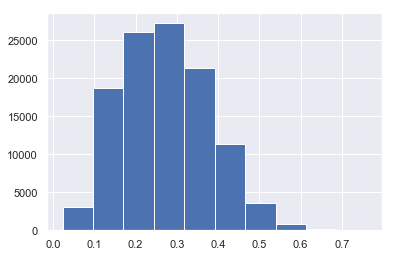

In [207]:
test_preds.loan_default.hist()

In [46]:
filename="{:%Y-%m-%d_%H_%M}_sub.csv".format(datetime.now())
submission.to_csv(filename, index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D1156A4CF8>,
      dtype=object)

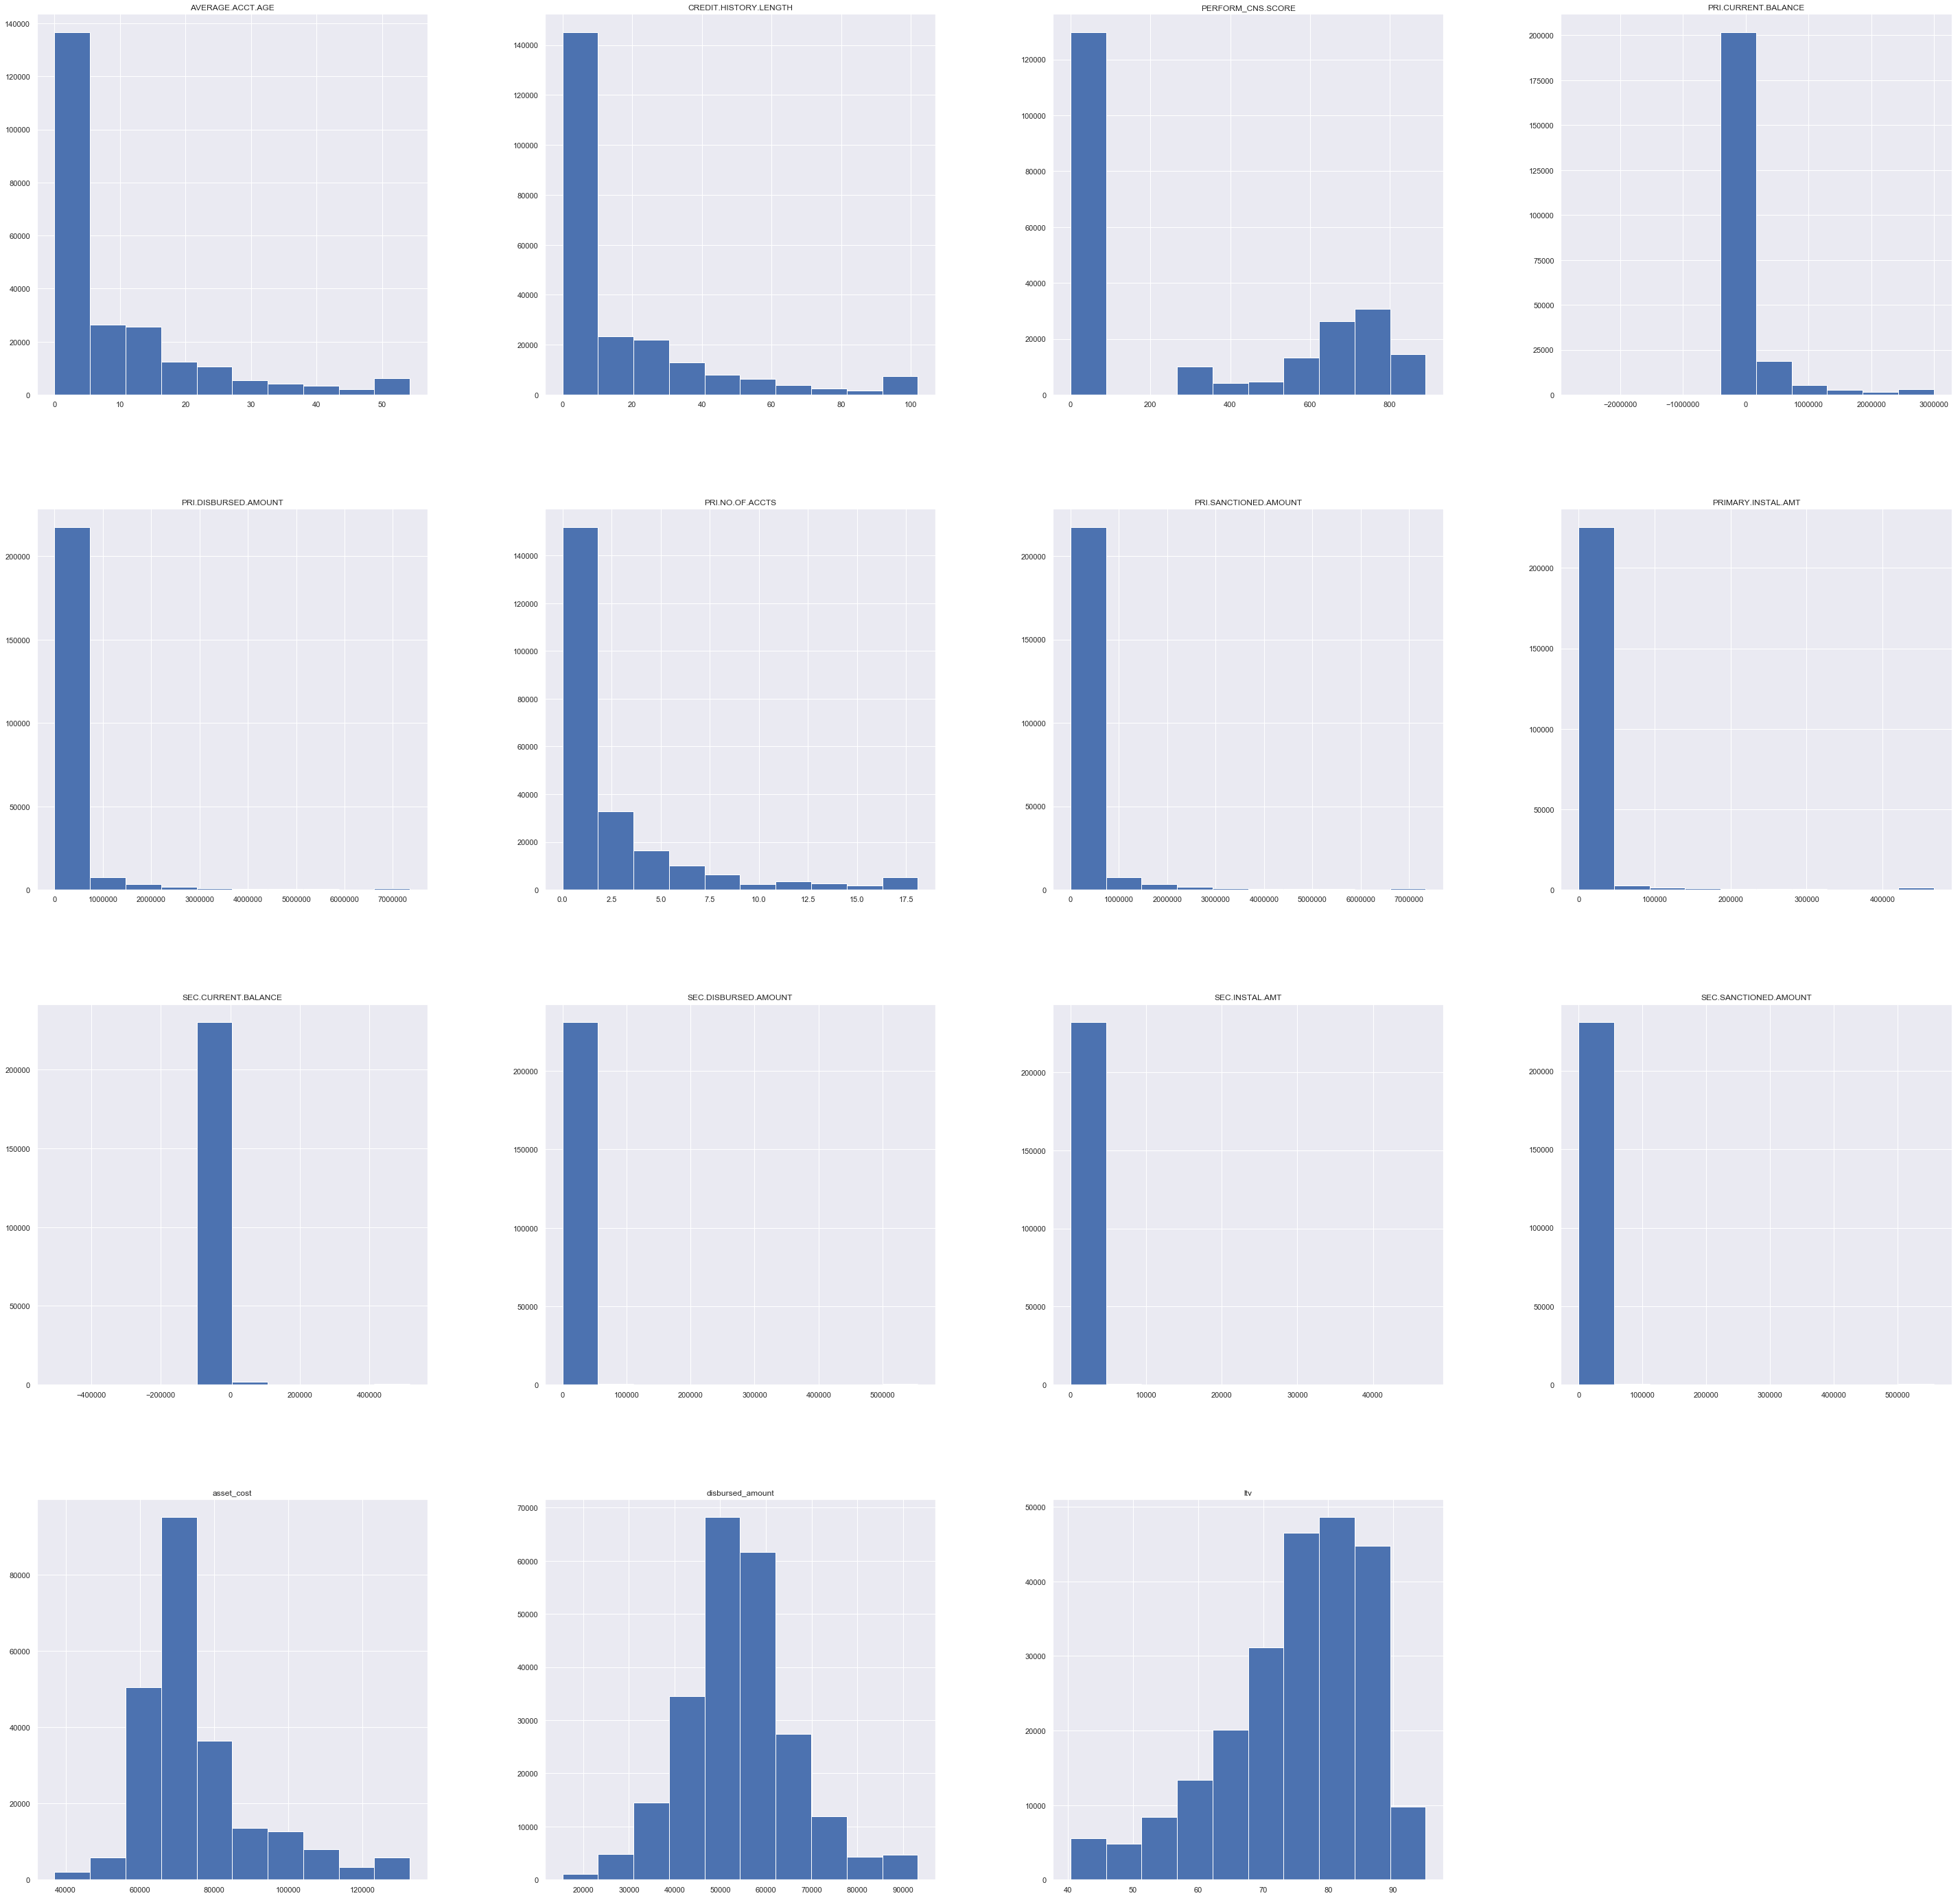

In [213]:
train[num_col].hist(figsize = (50, 50))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D1169D3E10>,
      dtype=object)

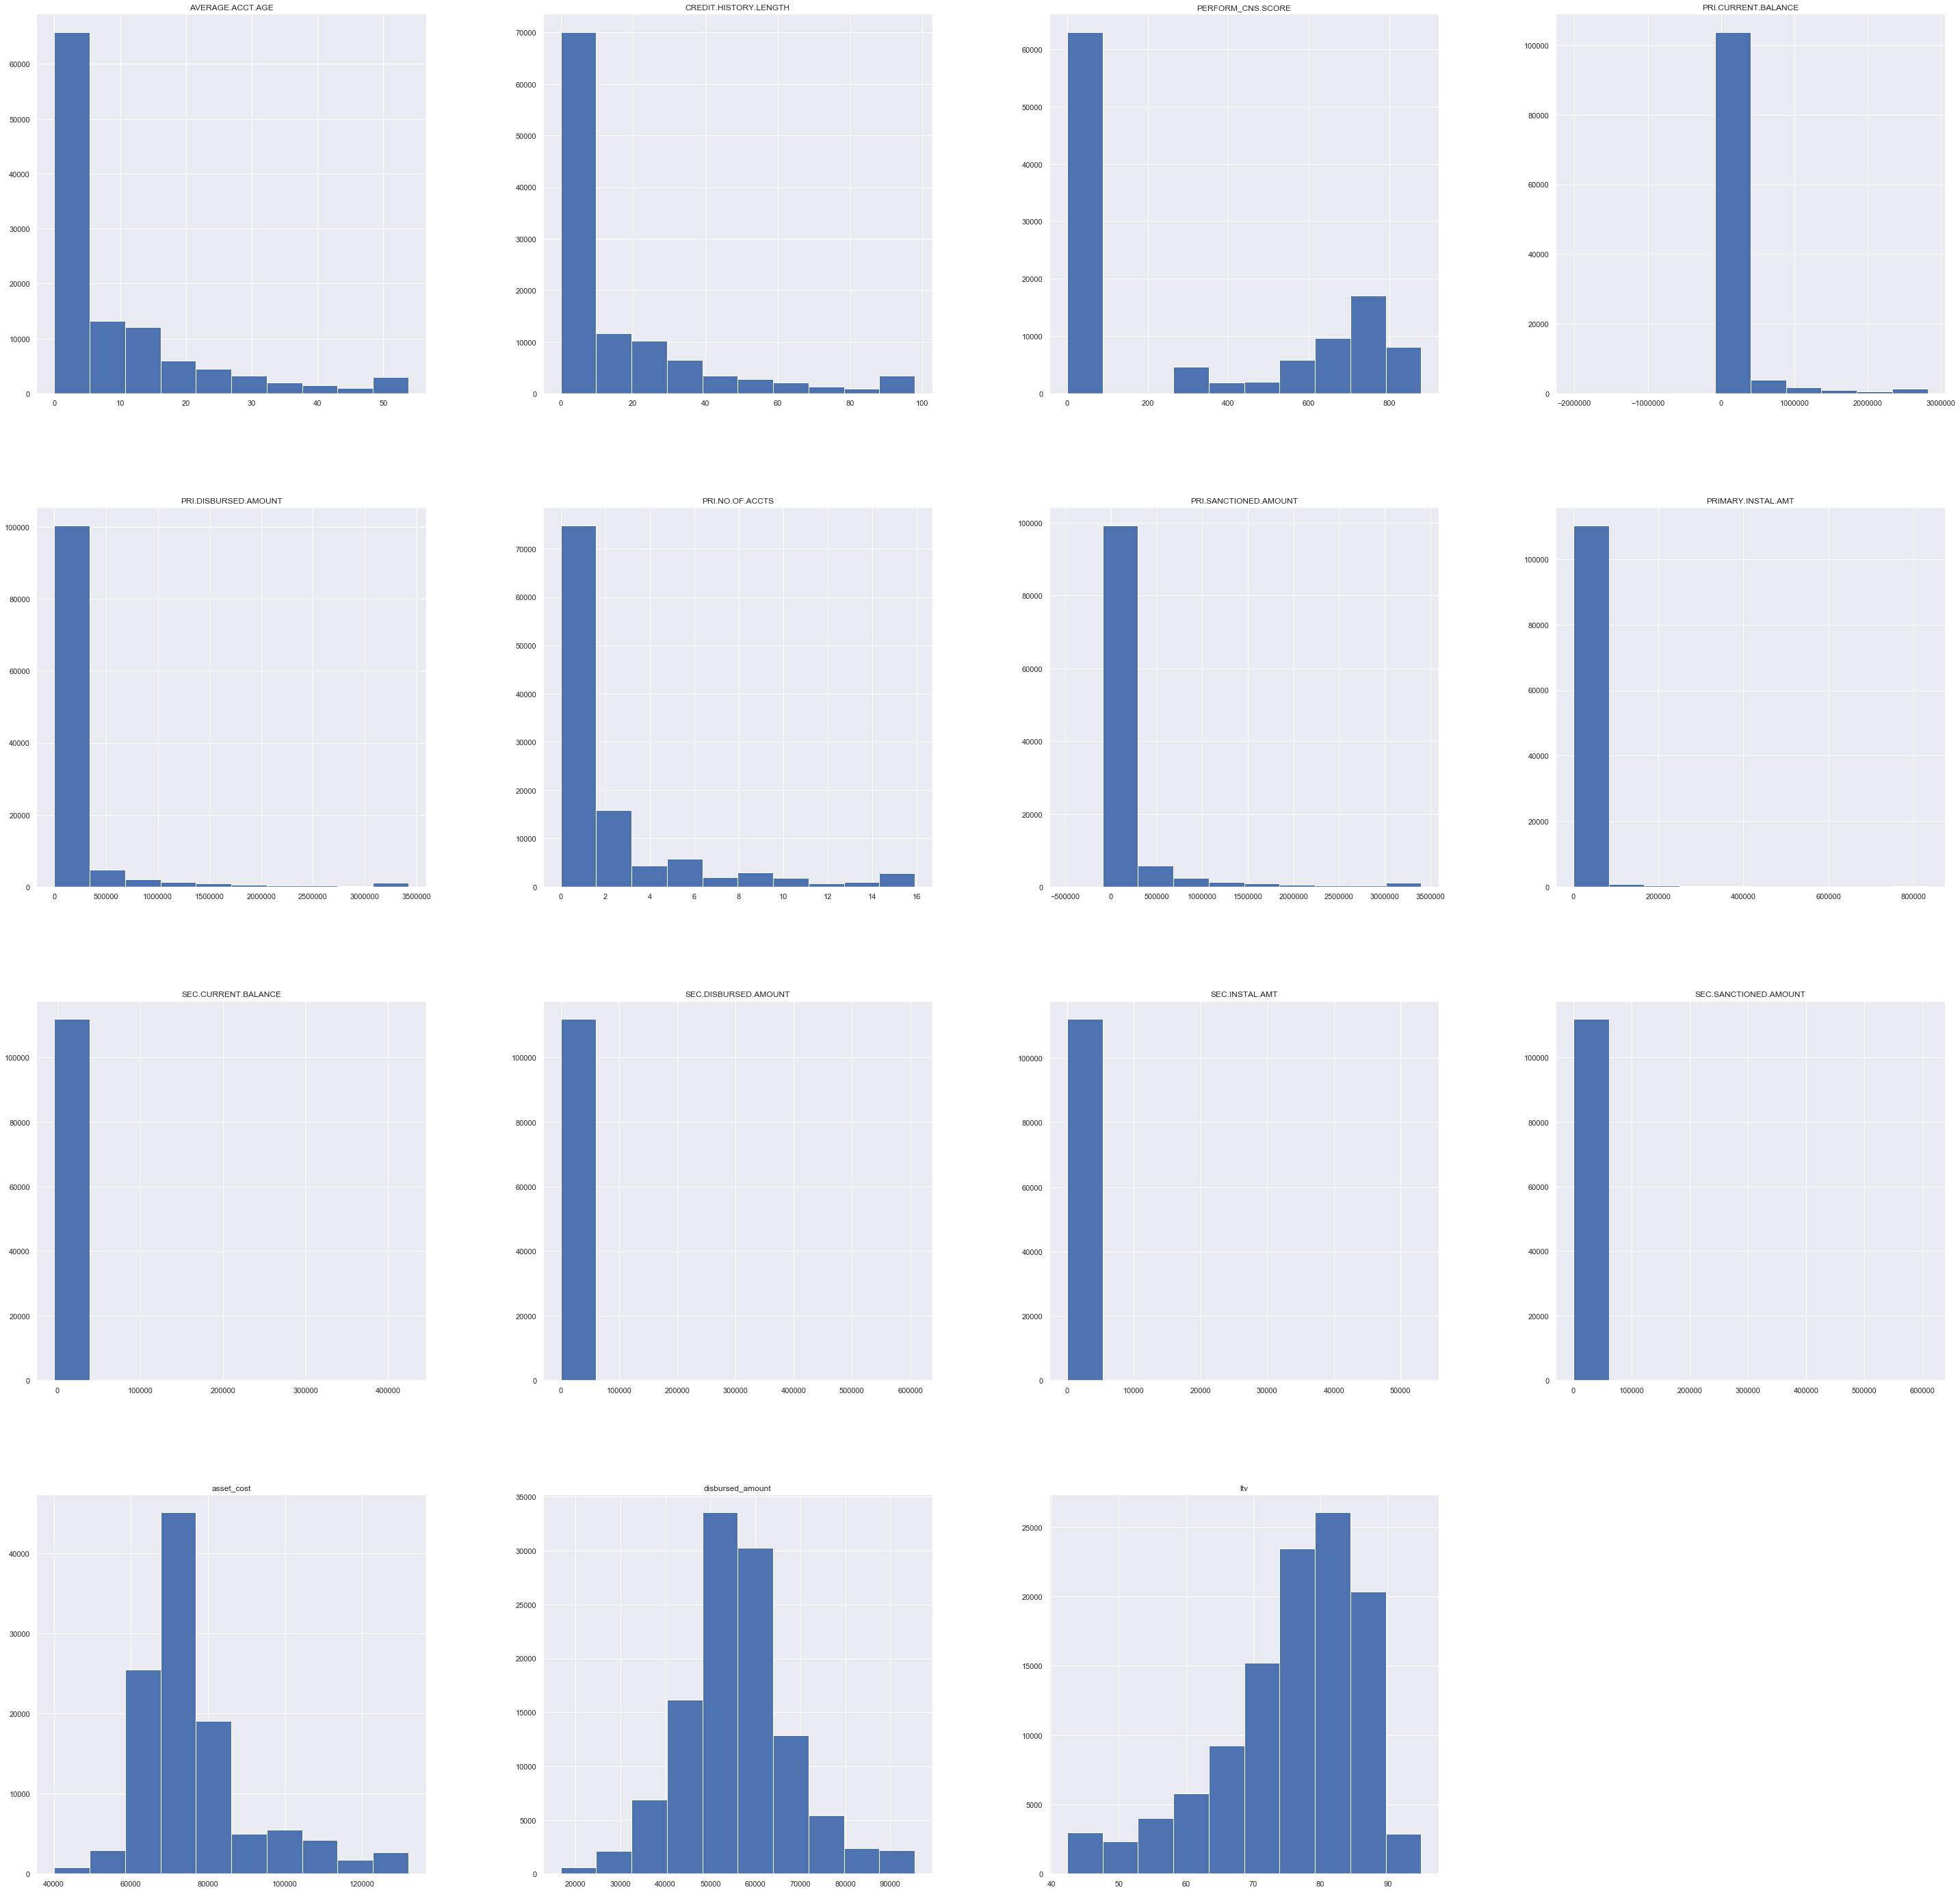

In [214]:
test[num_col].hist(figsize = (50, 50))

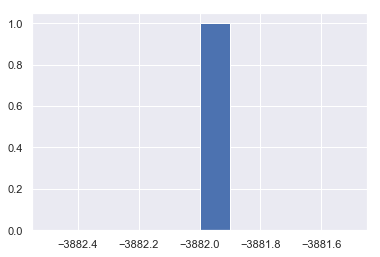

In [228]:
test[test['SEC.CURRENT.BALANCE']<-550]['SEC.CURRENT.BALANCE'].hist()

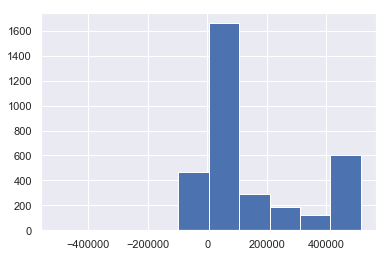

In [224]:
train[abs(train['SEC.CURRENT.BALANCE'])>10]['SEC.CURRENT.BALANCE'].hist()

In [155]:
train.columns , test.columns

(Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
        'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
        'Employment.Type',
        ...
        'asset_cost*PRIMARY.INSTAL.AMT', 'asset_cost/PRIMARY.INSTAL.AMT',
        'asset_cost-SEC.DISBURSED.AMOUNT', 'asset_cost+SEC.DISBURSED.AMOUNT',
        'asset_cost*SEC.DISBURSED.AMOUNT', 'asset_cost/SEC.DISBURSED.AMOUNT',
        'asset_cost-PRI.SANCTIONED.AMOUNT', 'asset_cost+PRI.SANCTIONED.AMOUNT',
        'asset_cost*PRI.SANCTIONED.AMOUNT', 'asset_cost/PRI.SANCTIONED.AMOUNT'],
       dtype='object', length=619),
 Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
        'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
        'Employment.Type',
        ...
        'asset_cost*PRIMARY.INSTAL.AMT', 'asset_cost/PRIMARY.INSTAL.AMT',
        'asset_cost-SEC.DISBURSED.AMOUNT', 'asset_cost+SEC.DISBURSED.AMOUNT',
        'asset_cost*SEC.DISBURSED

In [155]:
train.columns , test.columns

(Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
        'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
        'Employment.Type',
        ...
        'asset_cost*PRIMARY.INSTAL.AMT', 'asset_cost/PRIMARY.INSTAL.AMT',
        'asset_cost-SEC.DISBURSED.AMOUNT', 'asset_cost+SEC.DISBURSED.AMOUNT',
        'asset_cost*SEC.DISBURSED.AMOUNT', 'asset_cost/SEC.DISBURSED.AMOUNT',
        'asset_cost-PRI.SANCTIONED.AMOUNT', 'asset_cost+PRI.SANCTIONED.AMOUNT',
        'asset_cost*PRI.SANCTIONED.AMOUNT', 'asset_cost/PRI.SANCTIONED.AMOUNT'],
       dtype='object', length=619),
 Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
        'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
        'Employment.Type',
        ...
        'asset_cost*PRIMARY.INSTAL.AMT', 'asset_cost/PRIMARY.INSTAL.AMT',
        'asset_cost-SEC.DISBURSED.AMOUNT', 'asset_cost+SEC.DISBURSED.AMOUNT',
        'asset_cost*SEC.DISBURSED

In [216]:
train['SEC.CURRENT.BALANCE'].describe()

count    233154.000000
mean       2182.049816
std       28932.710270
min     -505283.191090
25%           0.000000
50%           0.000000
75%           0.000000
max      516138.776729
Name: SEC.CURRENT.BALANCE, dtype: float64